# "Corona visualizations"
> "Awesome summary"
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [fastpages, jupyter]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

this notebook is heavily inspired by: https://covid19dashboards.com/covid-compare-permillion/

In [1]:
#hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
from jinja2 import Template
from IPython.display import HTML
%config InlineBackend.figure_format = 'retina'

chart_width = 850
chart_height= 400
import covid_overview as covid
# source: https://colab.research.google.com/github/github/covid19-dashboard/blob/master/_notebooks/2020-03-19-cases-and-deaths-per-million.ipynb

In [2]:
#hide
int_countries = ["China", "Italy", "Spain", "France", "United Kingdom", "Germany", "United States","South Korea",'US']

In [3]:
#hide
def load_individual_timeseries(name):
    base_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series'
    url = f'{base_url}/time_series_19-covid-{name}.csv'
    df = pd.read_csv(url, 
                     index_col=['Country/Region', 'Province/State', 'Lat', 'Long'])
    df['type'] = name.lower()
    df.columns.name = 'date'
    
    df = (df.set_index('type', append=True)
            .reset_index(['Lat', 'Long'], drop=True)
            .stack()
            .reset_index()
            .set_index('date')
         )
    df.index = pd.to_datetime(df.index)
    df.columns = ['country', 'state', 'type', 'cases']
    
    # Move HK to country level
    df.loc[df.state =='Hong Kong', 'country'] = 'Hong Kong'
    df.loc[df.state =='Hong Kong', 'state'] = np.nan
    
    # Aggregate large countries split by states
    df = pd.concat([df, 
                    (df.loc[~df.state.isna()]
                     .groupby(['country', 'date', 'type'])
                     .sum()
                     .rename(index=lambda x: x+' (total)', level=0)
                     .reset_index(level=['country', 'type']))
                   ])
    return df

def load_data(drop_states=False, p_crit=.05, filter_n_days_100=None):
    df = load_individual_timeseries('Confirmed')
    df = df.rename(columns={'cases': 'confirmed'})
    if drop_states:
        # Drop states for simplicity
        df = df.loc[df.state.isnull()]
        
    # Estimated critical cases
    df = df.assign(critical_estimate=df.confirmed*p_crit)

    # Compute days relative to when 100 confirmed cases was crossed
    df.loc[:, 'days_since_100'] = np.nan
    for country in df.country.unique():
        if not df.loc[(df.country == country), 'state'].isnull().all():
            for state in df.loc[(df.country == country), 'state'].unique():
                df.loc[(df.country == country) & (df.state == state), 'days_since_100'] = \
                    np.arange(-len(df.loc[(df.country == country) & (df.state == state) & (df.confirmed < 100)]), 
                              len(df.loc[(df.country == country) & (df.state == state) & (df.confirmed >= 100)]))
        else:
            df.loc[(df.country == country), 'days_since_100'] = \
                np.arange(-len(df.loc[(df.country == country) & (df.confirmed < 100)]), 
                          len(df.loc[(df.country == country) & (df.confirmed >= 100)]))

    # Add recovered cases
    df_recovered = load_individual_timeseries('Recovered')
    df_r = df_recovered.set_index(['country', 'state'], append=True)[['cases']]
    df_r.columns = ['recovered']

    # Add deaths
    df_deaths = load_individual_timeseries('Deaths')
    df_d = df_deaths.set_index(['country', 'state'], append=True)[['cases']]
    df_d.columns = ['deaths']

    df = (df.set_index(['country', 'state'], append=True)
            .join(df_r)
            .join(df_d)
            .reset_index(['country', 'state'])
    )
    
    if filter_n_days_100 is not None:
        # Select countries for which we have at least some information
        countries = pd.Series(df.loc[df.days_since_100 >= filter_n_days_100].country.unique())
        df = df.loc[lambda x: x.country.isin(countries)]

    return df

In [4]:
#hide_input

corona_df = load_data(drop_states=True, filter_n_days_100=2)
# We only have data for China after they already had a significant number of cases.
# They also are not well modeled by the exponential, so we drop them here for simplicity.
#corona_df = corona_df.loc[lambda x: x.country != 'China (total)']

#countries = corona_df.country.unique()
#n_countries = len(countries)
corona_df = corona_df.loc[lambda x: (x.days_since_100 >= 0)]
df = (corona_df
             .reset_index()
            #.query("country == 'Germany'")
             .drop(columns =['state','type','critical_estimate','days_since_100']))

df_melted = pd.melt(df, id_vars=["date","country"], var_name="status", value_name="value")
print(f"Last updated of dataset: {max(corona_df.reset_index()['date']).strftime('%d %B, %Y')}")

Last updated of dataset: 21 March, 2020


In [5]:
#hide
COL_REGION = 'Country/Region'
europe_countries = covid.mapping['df'].pipe(lambda d: d[d['Continent'].eq('Europe')])['Name'].values
filter_europe = lambda d: d[d['Country/Region'].isin(int_countries)]
kpis_info = [
    {'title': 'Germany', 'prefix': 'GE'},
    {'title': 'Italy', 'prefix': 'IT'},
    {'title': 'Spain', 'prefix': 'SP'}]
data = covid.gen_data(region=COL_REGION, filter_frame=filter_europe, kpis_info=kpis_info)

## Overview
modified from: https://covid19dashboards.com/covid-overview/

In [6]:
#hide_input
template = Template(covid.get_template(covid.paths['overview']))
dt_cols, LAST_DATE_I = data['dt_cols'], data['dt_last']
html = template.render(
    D=data['summary'], table=data['table'],
    newcases=data['newcases'].loc[:, dt_cols[LAST_DATE_I - 10]:dt_cols[LAST_DATE_I]],
    COL_REGION=COL_REGION,
    KPI_CASE='Latest Covid-19 numbers',
    KPIS_INFO=kpis_info,
    LEGEND_DOMAIN=[5, 50, 500, np.inf],
    np=np, pd=pd, enumerate=enumerate)
HTML(f'<div>{html}</div>')

## New cases

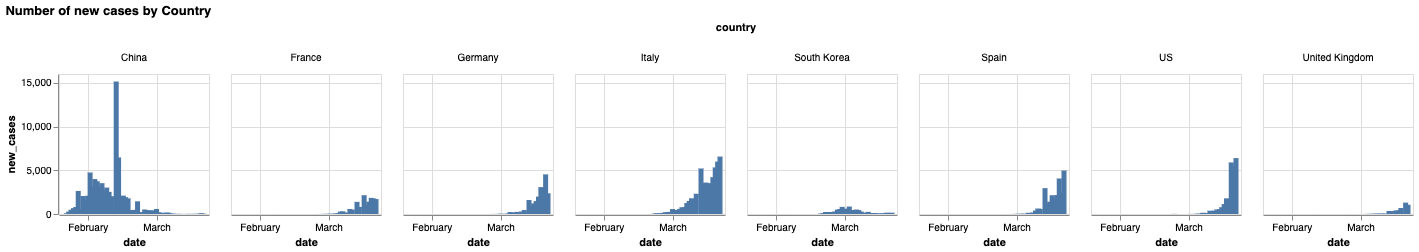

In [7]:
#hide_input
new_cases_df = data['newcases'].reset_index().rename(columns={'Country/Region':'country'})
new_cases_melted_df = pd.melt(new_cases_df, id_vars=["country"], var_name="date", value_name="new_cases")

alt.Chart(new_cases_melted_df).mark_bar().encode(
     x='date:T',
     y='new_cases:Q',
     #color='country:N',
     column='country:N',
     #facet=alt.Facet('country:O', columns=1),
    ).properties(
    title='Number of new cases by Country',
    width=150,
    height=140
)

In [8]:
#hide 
data = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv", error_bad_lines=False)
data = data.drop(columns=["Lat", "Long"])
data = data.melt(id_vars= ["Province/State", "Country/Region"])
data = pd.DataFrame(data.groupby(['Country/Region', "variable"]).sum())
data.reset_index(inplace=True)  
data = data.rename(columns={"Country/Region": "location", "variable": "date", "value": "total_cases"})
data['date'] =pd.to_datetime(data.date)
data = data.sort_values(by = "date")
data.loc[data.location == "US","location"] = "United States"
data.loc[data.location == "Korea, South","location"] = "South Korea"

data_pwt = pd.read_stata("https://www.rug.nl/ggdc/docs/pwt91.dta")

filter1 = data_pwt["year"] == 2017
data_pop = data_pwt[filter1]
data_pop = data_pop[["country","pop"]]
data_pop.loc[data_pop.country == "Republic of Korea","country"] = "South Korea"
data_pop.loc[data_pop.country == "Iran (Islamic Republic of)","country"] = "Iran"

# per habitant
data_pc = data.copy()
# countries = ["China", "Italy", "Spain", "France", "United Kingdom", "Germany", 
#              "Portugal", "United States", "Singapore","South Korea", "Japan", 
#              "Brazil","Iran"]

data_countries = []
data_countries_pc = []

# compute per habitant
for i in countries:
    data_pc.loc[data_pc.location == i,"total_cases"] = data_pc.loc[data_pc.location == i,"total_cases"]/float(data_pop.loc[data_pop.country == i, "pop"])

    # get each country time series
filter1 = data_pc["total_cases"] > 1
for i in countries:
    filter_country = data_pc["location"]== i
    data_countries_pc.append(data_pc[filter_country & filter1])

NameError: name 'countries' is not defined

## Covid-19 deaths per million inhabitants

In [ ]:
#hide_input
# Stack data to get it to Altair dataframe format
data_countries_pc2 = data_countries_pc.copy()
for i in range(0,len(countries)):
    data_countries_pc2[i] = data_countries_pc2[i].reset_index()
    data_countries_pc2[i]['n_days'] = data_countries_pc2[i].index
    data_countries_pc2[i]['log_cases'] = np.log(data_countries_pc2[i]["total_cases"])
data_plot = data_countries_pc2[0]
for i in range(1, len(countries)):    
    data_plot = pd.concat([data_plot, data_countries_pc2[i]], axis=0)
data_plot["trend_2days"] = data_plot["n_days"]*1/2
data_plot["trend_4days"] = data_plot["n_days"]*1/4
data_plot["trend_12days"] = data_plot["n_days"]*1/12
data_plot["trend_2days_label"] = "Doubles every 2 days"
data_plot["trend_4days_label"] = "Doubles evey 4 days"
data_plot["trend_12days_label"] = "Doubles every 12 days"


# Plot it using Altair
source = data_plot

scales = alt.selection_interval(bind='scales')
#selection = alt.selection_multi(fields=['location'], bind='legend')

base = alt.Chart(source, title = "COVID-19 Deaths Per Million of Inhabitants").encode(
    x = alt.X('n_days:Q', title = "Days passed since reaching 1 death per million"),
    y = alt.Y("log_cases:Q",title = "Log of deaths per million"),
    color = alt.Color('location:N', legend=alt.Legend(title="Country", labelFontSize=15, titleFontSize=17),
                     scale=alt.Scale(scheme='tableau20')),
    #opacity = alt.condition(selection, alt.value(1), alt.value(0.1))
)

lines = base.mark_line().add_selection(
    scales
).properties(
   width=chart_width,
   height=chart_height
)
#.add_selection(
#    selection
#)

trend_2d = alt.Chart(source).encode(
    x = "n_days:Q",
    y = alt.Y("trend_2days:Q",  scale=alt.Scale(domain=(0, max(data_plot["log_cases"])))),
).mark_line(color="grey", strokeDash=[3,3])


labels = pd.DataFrame([{'label': 'Doubles every 2 days', 'x_coord': 6, 'y_coord': 4},
                       {'label': 'Doubles every 4 days', 'x_coord': 17, 'y_coord': 3.5},
                       {'label': 'Doubles every 12 days', 'x_coord': 25, 'y_coord': 2.5},
                      ])
trend_label = (alt.Chart(labels)
                    .mark_text(align='left', dx=-55, dy=-15, fontSize=12, color="grey")
                    .encode(x='x_coord:Q',
                            y='y_coord:Q',
                            text='label:N')
                   )

trend_4d = alt.Chart(source).mark_line(color="grey", strokeDash=[3,3]).encode(
    x = "n_days:Q",
    y = alt.Y("trend_4days:Q",  scale=alt.Scale(domain=(0, max(data_plot["log_cases"])))),
)

trend_12d = alt.Chart(source).mark_line(color="grey", strokeDash=[3,3]).encode(
    x = "n_days:Q",
    y = alt.Y("trend_12days:Q",  scale=alt.Scale(domain=(0, max(data_plot["log_cases"])))),
)


(
(trend_2d + trend_4d + trend_12d + trend_label + lines)
.configure_title(fontSize=20)
.configure_axis(labelFontSize=15,titleFontSize=18)
)

In [ ]:
#hide_input
label = 'Deaths'
temp = pd.concat([x.copy() for x in data_countries_pc]).loc[lambda x: x.date >= '3/1/2020']

metric_name = f'{label} per Million'
temp.columns = ['Country', 'date', metric_name]
# temp.loc[:, 'month'] = temp.date.dt.strftime('%Y-%m')
temp.loc[:, f'Log of {label} per Million'] = temp[f'{label} per Million'].apply(lambda x: np.log(x))

temp.groupby('Country').last()

In [ ]:
#hide
# Get data and clean it



data = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv", error_bad_lines=False)
data = data.drop(columns=["Lat", "Long"])
data = data.melt(id_vars= ["Province/State", "Country/Region"])
data = pd.DataFrame(data.groupby(['Country/Region', "variable"]).sum())
data.reset_index(inplace=True)  
data = data.rename(columns={"Country/Region": "location", "variable": "date", "value": "total_cases"})
data['date'] =pd.to_datetime(data.date)
data = data.sort_values(by = "date")
data.loc[data.location == "US","location"] = "United States"
data.loc[data.location == "Korea, South","location"] = "South Korea"

# Population data (last year is 2017 which is what we use)
data_pwt = pd.read_stata("https://www.rug.nl/ggdc/docs/pwt91.dta")

filter1 = data_pwt["year"] == 2017
data_pop = data_pwt[filter1]
data_pop = data_pop[["country","pop"]]
data_pop.loc[data_pop.country == "Republic of Korea","country"] = "South Korea"
data_pop.loc[data_pop.country == "Iran (Islamic Republic of)","country"] = "Iran"

# per habitant
data_pc = data.copy()

# I can add more countries if needed

data_countries = []
data_countries_pc = []

# compute per habitant
for i in countries:
    data_pc.loc[data_pc.location == i,"total_cases"] = data_pc.loc[data_pc.location == i,"total_cases"]/float(data_pop.loc[data_pop.country == i, "pop"])
    
# get each country time series
filter1 = data_pc["total_cases"] > 1

for i in countries:
    filter_country = data_pc["location"]== i
    data_countries_pc.append(data_pc[filter_country & filter1])

## Covid-19 confirmed cases per million inhabitants

In [ ]:
#hide_input
# Stack data to get it to Altair dataframe format
data_countries_pc2 = data_countries_pc.copy()
for i in range(0,len(countries)):
    data_countries_pc2[i] = data_countries_pc2[i].reset_index()
    data_countries_pc2[i]['n_days'] = data_countries_pc2[i].index
    data_countries_pc2[i]['log_cases'] = np.log(data_countries_pc2[i]["total_cases"])
data_plot = data_countries_pc2[0]
for i in range(1, len(countries)):    
    data_plot = pd.concat([data_plot, data_countries_pc2[i]], axis=0)
data_plot["trend_2days"] = data_plot["n_days"]*1/2
data_plot["trend_4days"] = data_plot["n_days"]*1/4
data_plot["trend_12days"] = data_plot["n_days"]*1/12
data_plot["trend_2days_label"] = "Doubles every 2 days"
data_plot["trend_4days_label"] = "Doubles evey 4 days"
data_plot["trend_12days_label"] = "Doubles every 12 days"


# Plot it using Altair
source = data_plot

scales = alt.selection_interval(bind='scales')
#selection = alt.selection_multi(fields=['location'], bind='legend')

base = alt.Chart(source, title = "COVID-19 Confirmed Cases Per Million of Inhabitants").encode(
    x = alt.X('n_days:Q', title = "Days passed since reaching 1 case per million"),
    y = alt.Y("log_cases:Q",title = "Log of confirmed cases per million"),
    color = alt.Color('location:N', legend=alt.Legend(title="Country", labelFontSize=15, titleFontSize=17),
                     scale=alt.Scale(scheme='tableau20')),
    #opacity = alt.condition(selection, alt.value(1), alt.value(0.1))
).properties(
    width=chart_width,
    height=chart_height
)

lines = base.mark_line().add_selection(
    scales
)
# .add_selection(
#     selection
# )

trend_2d = alt.Chart(source).encode(
    x = "n_days:Q",
    y = alt.Y("trend_2days:Q",  scale=alt.Scale(domain=(0, max(data_plot["log_cases"])))),
).mark_line( strokeDash=[3,3], color="grey")

labels = pd.DataFrame([{'label': 'Doubles every 2 days', 'x_coord': 10, 'y_coord': 6},
                       {'label': 'Doubles every 4 days', 'x_coord': 30, 'y_coord': 6},
                       {'label': 'Doubles every 12 days', 'x_coord': 45, 'y_coord': 4},
                      ])
trend_label = (alt.Chart(labels)
                    .mark_text(align='left', dx=-55, dy=-15, fontSize=12, color="grey")
                    .encode(x='x_coord:Q',
                            y='y_coord:Q',
                            text='label:N')
                   )


trend_4d = alt.Chart(source).mark_line(color="grey", strokeDash=[3,3]).encode(
    x = "n_days:Q",
    y = alt.Y("trend_4days:Q",  scale=alt.Scale(domain=(0, max(data_plot["log_cases"])))),
)

trend_12d = alt.Chart(source).mark_line(color="grey", strokeDash=[3,3]).encode(
    x = "n_days:Q",
    y = alt.Y("trend_12days:Q",  scale=alt.Scale(domain=(0, max(data_plot["log_cases"])))),
)

(
(trend_2d  + trend_4d + trend_12d + trend_label + lines)
.configure_title(fontSize=20)
.configure_axis(labelFontSize=15,titleFontSize=18)
)

## Flatten the curve

In [ ]:
#collapse

alt.Chart(df_melted).mark_area().encode(
    x="date:T",
    y=alt.Y("value:Q", stack="normalize"),
    color="status:N",
    row=alt.Row('country:N', sort=['Germany', 'Italy', 'Spain'])
).properties(height=50, width=800)

In [ ]:
#collapse
alt.Chart(df_melted).mark_circle(
    opacity=0.8,
    stroke='black',
    strokeWidth=1
).encode(
    alt.X('date:T', axis=alt.Axis(labelAngle=45)),
    alt.Y('country:N'),
    alt.Size('value:Q',
        scale=alt.Scale(range=[0, 2000]),
        legend=alt.Legend(title='confirmed cases')
    ),
    alt.Color('country:N', legend=None)
).properties(
    width=850,
    height=820
).transform_filter(
    alt.datum.Entity != 'All natural disasters'
)